_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*Florian Burkardt & Franz Ruppert* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? ChatGPT for Coding Assistance, Code Generation for Plots, Explanation of Concepts* </span>

# Coding Lab 6

In this exercise we are going to fit a latent variable model (Poisson GPFA) to both toy data and real data from monkey primary visual cortex. For details, see [Ecker et al. 2014](https://www.cell.com/neuron/pdf/S0896-6273(14)00104-4.pdf).

## Preliminaries

### 1. Code 

The toolbox we are going to use contains an implementation of the EM algorithm to fit the poisson-gpfa. 

Assuming you `git clone https://github.com/berenslab/poisson-gpfa` to the parent directory and have the following directory structure:


```
├── data/
│   └── nds_cl_6_data.mat
├── poisson-gpfa/
├── notebooks
│   └── CodingLab6.ipynb
├── matplotlib_style.txt
├── requirements.txt
```

then you can import the related functions via:

```
import sys
sys.path.append('../poisson-gpfa/')
sys.path.append('../poisson-gpfa/funs')

import funs.util as util
import funs.engine as engine
```

Change the paths if you have a different directory structure. For the details of the algorithm, please refer to the thesis `hooram_thesis.pdf` from ILIAS.

### 2. Data

Download the data file ```nds_cl_6_data.mat``` from ILIAS and save it in a ```data/``` folder.

In [188]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# style
import seaborn as sns

# poisson-gpfa
import sys

sys.path.append("../poisson-gpfa/")
sys.path.append("../poisson-gpfa/funs")

import funs.util as util
import funs.engine as engine

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-06-01 19:29:13CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.30.0

sklearn: 1.6.1

sys       : 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:43:39) [Clang 11.1.0 ]
pandas    : 2.2.3
IPython   : 8.30.0
numpy     : 2.2.4
matplotlib: 3.10.1
seaborn   : 0.13.2
scipy     : 1.15.2

Watermark: 2.5.0



In [189]:
plt.style.use("../matplotlib_style.txt")

## Task 1. Generate some toy data to test the poisson-GPFA code

We start by verifying our code on toy data. The cell below contains code to generate data for 30 neurons, 100 trials (1000 ms each) and 50ms bin size. The neurons' firing rate $\lambda_k$ is assumed to be a constant $d_k$ modulated by a one-dimensional latent state $x$, which is drawn from a Gaussian process:

$\lambda_k = \exp(c_kx + d_k)$

Each neuron's weight $c_k$ is drawn randomly from a normal distribution and spike counts are sampled form a Poisson distribution with rate $\lambda_k$.

Your task is to fit a Poisson GPFA model with one latent variable to this data (see `engine.PPGPFAfit`).

Hint: You can use `util.dataset?`, `engine.PPGPFAfit?` or `util.initializeParams?` to find out more about the provided package.

*Grading: 3 pts*

In [190]:
# ---------------------------------
# simulate a training set (0.5 pts)
# ---------------------------------

# Initialize random number generator

seed = 42

# Specify dataset & fitting parameters
n_neurons = 30
dur_trials = 1000
n_trials = 100
binsize = 50
n_latent = 1
# Sample from the model (make a toy dataset)
training_set = util.dataset(
    trialDur=dur_trials,
    binSize=binsize,
    numTrials=n_trials,
    xdim=n_latent,
    ydim=n_neurons,
    seed=seed,
)

+------------- Simulated Dataset Options -------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                 1000 | Duration of trials (ms):
                                                   50 | Size of bins (ms):
                                                  100 | Number of Trials
+-----------------------------------------------------+
Sampling trial 100 ...
Average firing rate per neuron in this dataset: 3.441 Hz.


### Fit the model

In [191]:
?util.initializeParams

Signature: util.initializeParams(xdim, ydim, experiment=None)
Docstring:
Initializes Poisson-GPFA model parameters.

Parameters:
  * xdim       : int, latent dimensionality to fit
  * ydim       : int, number of neurons in the dataset
  * experiment : (optional) If a third optional argument of util.dataset object is given, 
                 the fucntion returns a dictionary of parameters obtained by performing Poisson-
                 PCA Leave this argument empty to initialize randomly.
Returns:
     A dictionary of model parameters.
File:      ~/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/poisson-gpfa/funs/util.py
Type:      function

In [192]:
?engine.PPGPFAfit

Init signature:
engine.PPGPFAfit(
    experiment,
    initParams=None,
    xdim=2,
    inferenceMethod='laplace',
    maxEMiter=50,
    optimLogLamb=False,
    CdOptimMethod='TNC',
    tauOptimMethod='TNC',
    verbose=False,
    EMmode='Online',
    batchSize=5,
    onlineParamUpdateMethod='diag',
    hessTol=None,
    stepPow=0.75,
    updateCdJointly=True,
    fullyUpdateTau=False,
    extractAllTraj=False,
    extractAllTraj_trueParams=False,
    getPredictionErr=False,
    CdMaxIter=None,
    tauMaxIter=None,
)
Docstring:     
Poisson-GPFA model fit given a neural population spike data. 

Input Attributes:
  * experiment : (util.dataset object), required
    - A dataset object with the following attributes:
        experiment.data     - A list of dictionaries in the following format:
          experiment.data[trial]['Y'] - numpy array of shape (#time bins, # neurons)
        experiment.T        - number of time bins, all trials must have the same length
        experiment.trialDur

In [193]:
# -----------------------
# fit the model (0.5 pts)
# -----------------------

# Initialize parameters using Poisson-PCA
params = util.initializeParams(xdim=n_latent, ydim=n_neurons, experiment=training_set)
# choose sensible parameters and run fit
fitToy = engine.PPGPFAfit(
    experiment=training_set, initParams=params, xdim=1, EMmode="Batch"
)

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   50 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  50 of  50, nPLL: = -261.6443
This dataset is a simulated dataset.
Processing performance against ground truth parameters...


In [194]:
# some useful functions
def allTrialsState(fit: engine.PPGPFAfit, p) -> np.ndarray:
    """Reshape the latent signal and the spike counts"""
    x = np.zeros([p, 0])
    for i in range(len(fit.infRes["post_mean"])):
        x = np.concatenate((x, fit.infRes["post_mean"][i]), axis=1)
    return x


def allTrialsX(training_set: util.dataset) -> np.ndarray:
    """Reshape the ground truth
    latent signal and the spike counts"""
    x_gt = np.array([])
    for i in range(len(training_set.data)):
        x_gt = np.concatenate((x_gt, training_set.data[i]["X"][0]), axis=0)
    return x_gt

### Plot the ground truth vs. inferred model
Verify your fit by plotting both ground truth and inferred parameters for:
1. weights C
2. biases d
3. latent state x 

Note that the sign of fitted latent state and its weights are ambiguous (you can flip both without changing the model). Make sure you correct the sign for the plot if it does not match the ground truth.

In [195]:
# All trials latent state vector
x_est = allTrialsState(fitToy, 1)
x_true = allTrialsX(training_set)

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_1838/3018022029.py:72: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 0.85, 1])


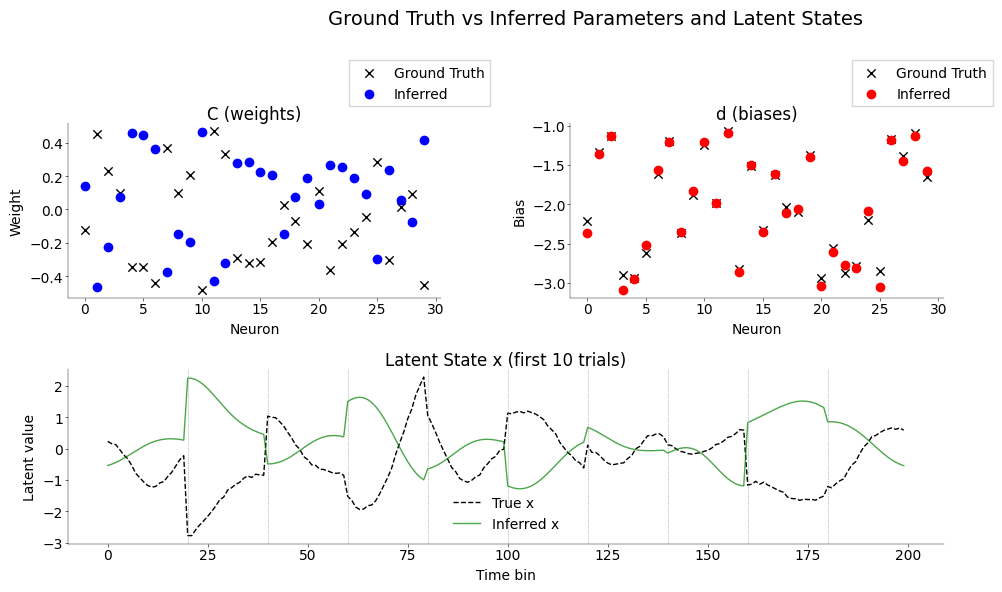

In [196]:
# ------------------------------------------------------
# Plot ground truth vs. inferred model
# Plot the weights `C`, biases `d` and latent states (2 pts)
# ------------------------------------------------------

# ----- Extract parameters -----

x_est = allTrialsState(fitToy, 1)
x_true = allTrialsX(training_set)
C_true = training_set.params["C"]  # shape: (neurons, xdim)
d_true = training_set.params["d"]  # shape: (neurons,)
C_est = fitToy.optimParams["C"]
d_est = fitToy.optimParams["d"]

# ----- flip signs -----

C_est_flip = -C_est
x_est_flip = -x_est

fig, ax = plt.subplot_mosaic([["C", "d"], ["latent", "latent"]], figsize=(12, 6))
fig.suptitle("Ground Truth vs Inferred Parameters and Latent States", fontsize=14)


ax["C"].scatter(
    np.arange(len(C_true)),
    C_true[:, 0],
    label="Ground Truth",
    color="black",
    marker="x",
)
ax["C"].scatter(
    np.arange(len(C_est_flip)),
    C_est_flip[:, 0],
    label="Inferred",
    color="blue",
    marker="o",
)
ax["C"].set_title("C (weights)")
ax["C"].set_xlabel("Neuron")
ax["C"].set_ylabel("Weight")
ax["C"].legend(loc="upper right", bbox_to_anchor=(1.15, 1.4), frameon=True)


ax["d"].scatter(
    np.arange(len(d_true)), d_true, label="Ground Truth", color="black", marker="x"
)
ax["d"].scatter(np.arange(len(d_est)), d_est, label="Inferred", color="red", marker="o")
ax["d"].set_title("d (biases)")
ax["d"].set_xlabel("Neuron")
ax["d"].set_ylabel("Bias")
ax["d"].legend(loc="upper right", bbox_to_anchor=(1.15, 1.4), frameon=True)


T = training_set.T
subset_trials = 10  # Plot only first 10 trials for clarity
trial_boundaries = np.arange(1, subset_trials) * T

# Plot true and estimated latent states over subset of trials
ax["latent"].plot(
    x_true[: subset_trials * T], label="True x", color="black", linestyle="dashed"
)
ax["latent"].plot(
    x_est_flip[0, : subset_trials * T], label="Inferred x", color="green", alpha=0.7
)
for b in trial_boundaries:
    ax["latent"].axvline(x=b, color="gray", linestyle=":", linewidth=0.5)
ax["latent"].set_title("Latent State x (first 10 trials)")
ax["latent"].set_xlabel("Time bin")
ax["latent"].set_ylabel("Latent value")
ax["latent"].legend()

fig.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

The fit looks pretty good on this Toy Example. This is also due to the matching data and model latent state. 

## Task 2: Fit GPFA model to real data. 

We now fit the model to real data and cross-validate over the dimensionality of the latent variable.

*Grading: 4 pts*

### Load data

The cell below implements loading the data and encapsulates it into a class that matches the interface of the Poisson GPFA engine. You don't need to do anything here.

In [197]:
class EckerDataset:
    """Loosy class"""

    def __init__(
        self,
        path: str,
        subject_id: int = 0,
        ydim: int = 55,
        trialDur: int = 2000,
        binSize: int = 100,
        numTrials: int = 100,
        ydimData: bool = False,
        numTrData: bool = True,
    ):
        # T = binSize #int(trialDur/binSize)
        T = int(trialDur / binSize)
        matdat = sio.loadmat(path)
        self.matdat = matdat
        data = []
        trial_durs = []
        for trial_id in range(numTrials):
            trial_time = matdat["spikeTimes"][:, trial_id][0]
            trial_big_time = np.min(trial_time)
            trial_end_time = np.max(trial_time)
            trial_durs.append(trial_end_time - trial_big_time)
        for trial_id in range(numTrials):
            Y = []
            spike_time = []
            data.append(
                {
                    "Y": matdat["spikeCounts"][:, :, trial_id],
                    "spike_time": matdat["spikeTimes"][:, trial_id],
                }
            )
        self.T = T
        self.trial_durs = trial_durs
        self.data = data
        self.trialDur = trialDur
        self.binSize = binSize
        self.numTrials = numTrials
        self.ydim = ydim
        util.dataset.getMeanAndVariance(self)
        util.dataset.getAvgFiringRate(self)
        util.dataset.getAllRaster(self)

In [198]:
path = "../data/nds_cl_6_data.mat"
data = EckerDataset(path)

### Fit Poisson GPFA models and perform model comparison

Split the data into 80 trials used for training and 20 trials held out for performing model comparison. On the training set, fit models using one to five latent variables. Compute the performance of each model on the held-out test set.

Hint: You can use the `crossValidation` function in the Poisson GPFA package.

Optional: The `crossValidation` function computes the sum of the squared errors (SSE) on the test set, which is not ideal. The predictive log-likelihood under the Poisson model would be a better measure, which you are welcome to compute instead.

In [199]:
?util.crossValidation

Init signature:
util.crossValidation(
    experiment,
    numTrainingTrials=10,
    numTestTrials=2,
    maxXdim=6,
    maxEMiter=3,
    batchSize=5,
    inferenceMethod='laplace',
    learningMethod='batch',
)
Docstring:      <no docstring>
File:           ~/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/poisson-gpfa/funs/util.py
Type:           type
Subclasses:     

### Derivation for log-likelihood

_You can add your calculations in_ $\LaTeX$ _here_.

$p_\lambda(x_t) = \ldots$

$L(\lambda_k; x_1, ..., x_N) = \ldots$ 

$log(L) = l(\lambda_k; x_1, ..., x_N) = \ldots$

In [200]:
# ------------------------------
# Perfom cross validation (1 pt)
# ------------------------------

# do the actual cross validation
xval = util.crossValidation(
    experiment=data, numTrainingTrials=80, numTestTrials=20, maxXdim=5, maxEMiter=3
)

Assessing optimal latent dimensionality will take a long time.
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                    3 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:   3 of   3, nPLL: = -410.6725Performing leave-one-out cross validation...
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    2 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
         

In [201]:
print(xval.optimXdim)

5


### Plot the test error

Make a plot of the test error for the five different models. As a baseline, please also include the test error of a model without a latent variable. This is essentially the SSE of a constant rate model (or Poisson likelihood if you did the optional part above). Note: We assume a constant firing rate across trials, but not necessarily across time.

In [202]:
# --------------------------------------------------------------------------------
# Compute and plot the test errors for the different latent variable models (1 pt)
# --------------------------------------------------------------------------------

train_set, test_set = util.splitTrainingTestDataset(
    data, numTrainingTrials=80, numTestTrials=20
)


# compute baseline error
def fit_baseline_model(training_set):
    """
    Compute constant log firing rates (d) per neuron using training data.
    """
    ydim = training_set.ydim
    num_trials = training_set.numTrials
    T = training_set.T

    d = np.zeros(ydim)
    for nrn in range(ydim):
        rates = []
        for tr in range(num_trials):
            y = training_set.data[tr]["Y"][nrn]  # shape: (T,)
            rates.extend(y)
        mean_rate = np.mean(rates)
        d[nrn] = np.log(mean_rate + 1e-8)  # Avoid log(0)
    return {"d": d}


def eval_baseline_model(params, test_set):
    """
    Predict firing rates from the baseline model and compute squared error.
    """
    d = params["d"]  # log-rates
    ydim = test_set.ydim
    num_trials = test_set.numTrials
    T = test_set.T

    error = 0
    for tr in range(num_trials):
        for nrn in range(ydim):
            rate = np.exp(d[nrn])
            y_true = test_set.data[tr]["Y"][nrn]  # shape: (T,)
            y_pred = np.full_like(y_true, rate)
            error += np.sum((y_true - y_pred) ** 2)
    return error


baseline_params = fit_baseline_model(train_set)
baseline_error = eval_baseline_model(baseline_params, test_set)
print(baseline_error)

49130


In [203]:
print(xval.errs)

[np.float64(41428.20200718674), np.float64(40953.859383997325), np.float64(41194.816789773446), np.float64(40113.279292467465), np.float64(39818.85977375908)]


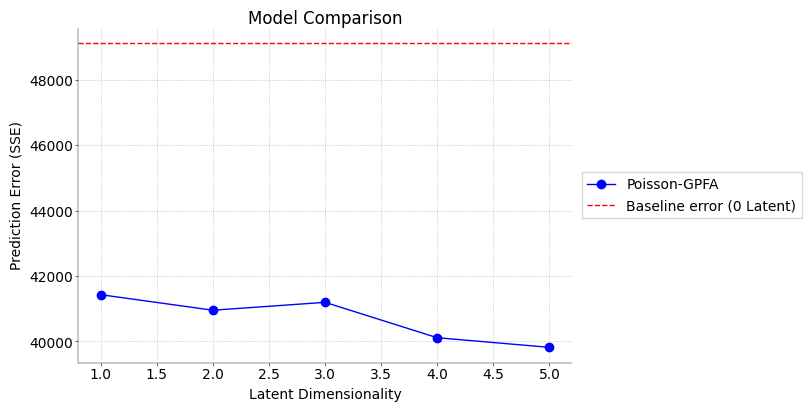

In [204]:
# -------------------------------------------------------------------------
# Compute and plot the test errors for the different latent variable models
# and answer the questions below (1+1 pts)
# -------------------------------------------------------------------------

# Your plot here
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 4))

# Plot model errors
ax.plot(
    np.arange(1, xval.maxXdim + 1), xval.errs, "o-", color="blue", label="Poisson-GPFA"
)

# Plot baseline error
ax.axhline(
    baseline_error, linestyle="--", color="red", label="Baseline error (0 Latent)"
)

# Labeling
ax.set_xlabel("Latent Dimensionality")
ax.set_ylabel("Prediction Error (SSE)")
ax.set_title("Model Comparison")

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0, frameon=True)

ax.grid(True, which="both", linestyle=":", linewidth=0.5)
# plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on right for legend
plt.show()


def enhanced_prediction_plot(xval, baseline_error=None, method_label="Poisson-GPFA"):
    plt.figure(figsize=(8, 4))
    dims = np.arange(1, xval.maxXdim + 1)
    plt.plot(dims, xval.errs, "o-", color="blue", label=method_label)

    if baseline_error is not None:
        plt.axhline(
            baseline_error, linestyle="--", color="red", label="Baseline (0 Latent)"
        )

    for i, err in enumerate(xval.errs, start=1):
        plt.annotate(
            f"{err:.1f}",
            (i, xval.errs[i - 1]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
            fontsize=8,
        )

    plt.xlabel("Latent Dimensionality")
    plt.ylabel("Prediction Error (SSE)")
    plt.title("Model Comparison: GPFA vs Baseline")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

### Questions

**Is the baseline error (0 latents) about what you expect in relation to the other models? Why or why not?**

- The baseline error fits our expectation as it is significantly higher then all the latent state models. This shows that the Neurons are probably not firing independently from each other but that there is some shared activity that is explained through the latent states. 


**Can you identify a "best model". If so, which is it and what does this say about the structure of the latent state?**

- The model with 4 latent variables has the lowest prediction error. One could think about calculating a AIC or a BIC to penalize the more complex models and to check wether the better prediction error is just due to a model maybe overfitting or just beeing more complex. We also have to keep in mind that we are not running the fit to convergence but just for 3 EM iterations which is quite low. However here we assume that the drop in the prediction error is significant enough to take the model with 5 latent variables as the "best model". This would mean that we assume that the firing of the neuron population is driven by five different underlying factors. Thus, the Neurons dont fire randomly but in response to these factors, which could be different sensory processes, common inputs, stimulus responses or something else entirely.

## Task 3. Visualization: population rasters and latent state.
Use the model with a single latent state. 

Create a raster plot where you show for each trial the spikes of all neurons as well as the trajectory of the latent state `x` (take care of the correct time axis). Sort the neurons by their weights `c_k`. Plot only the first 20 trials.

*Grading: 2 pts*

In [205]:
# Fit 1 Latent again to have some more EM iterations and get a better fit

# Initialize parameters using Poisson-PCA
params = util.initializeParams(xdim=n_latent, ydim=n_neurons, experiment=data)
# choose sensible parameters and run fit
fit1latent = engine.PPGPFAfit(
    experiment=data, initParams=params, xdim=1, EMmode="Batch"
)

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   50 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  50 of  50, nPLL: = -380.3208

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_1838/1955402871.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


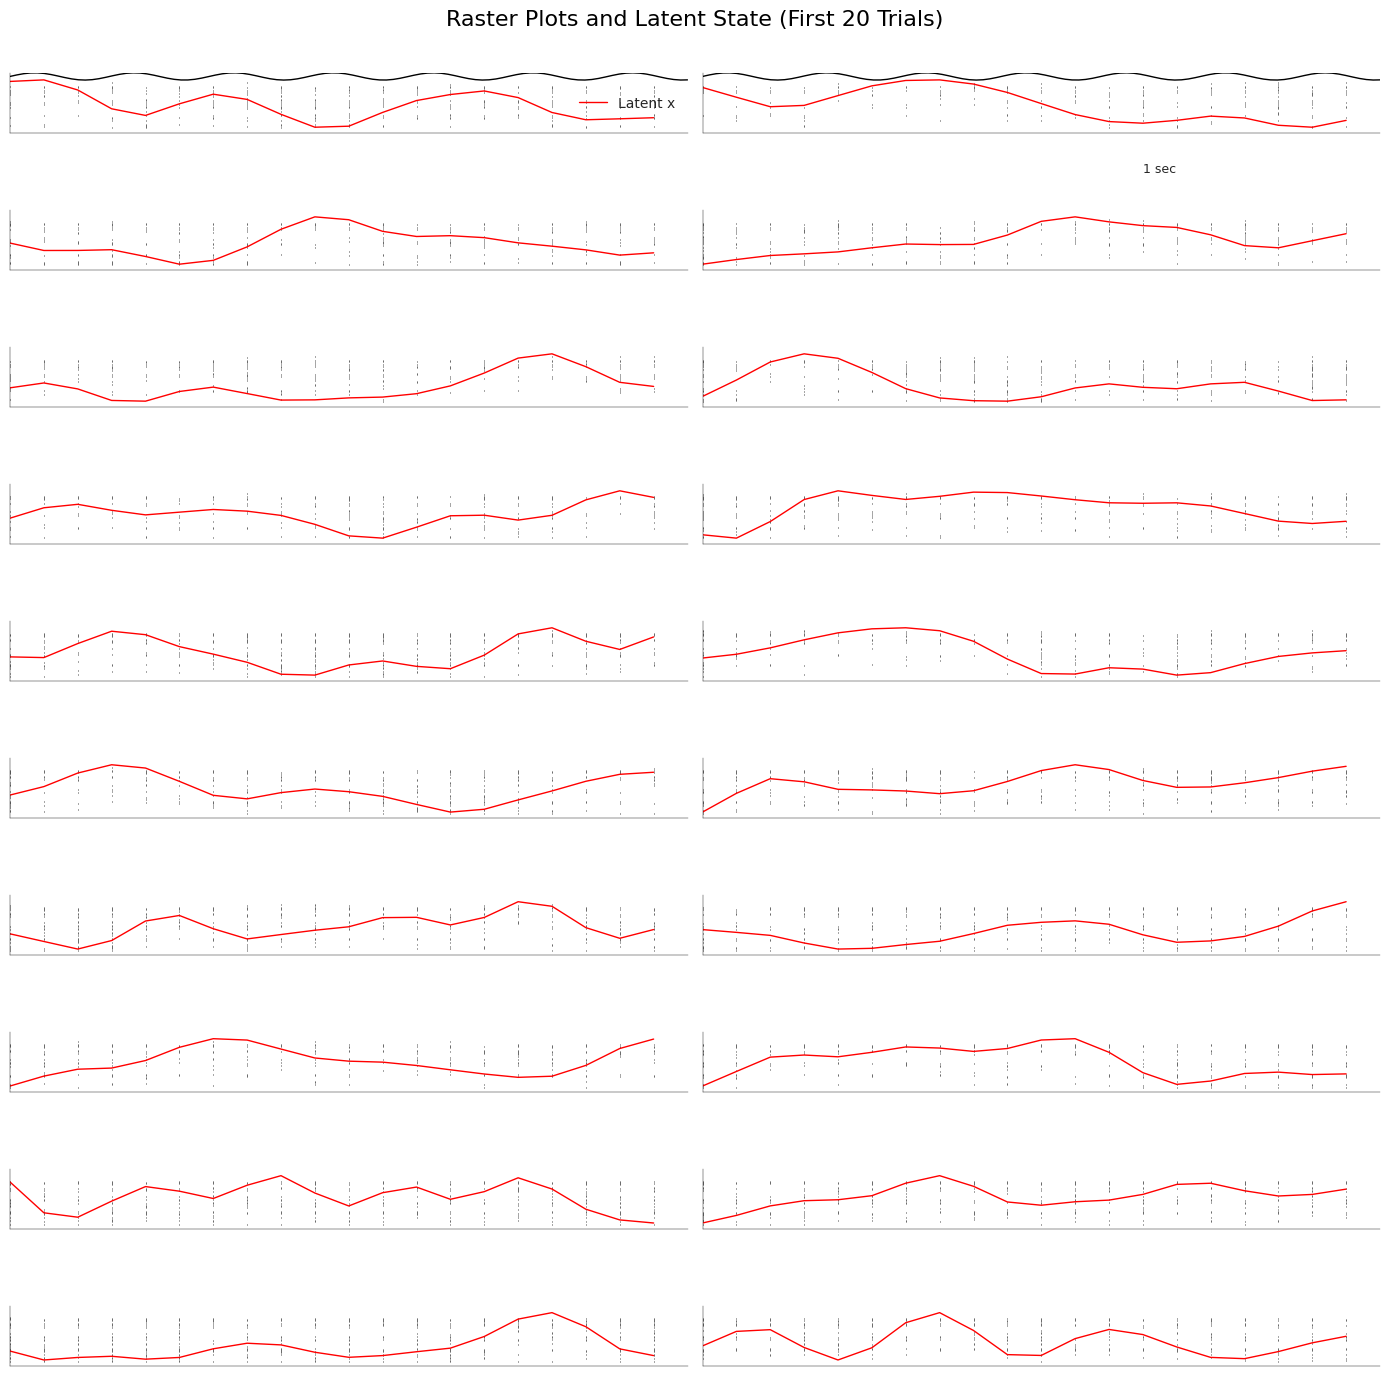

In [206]:
from numpy import matlib

n_trials_plot = 20
T = data.T
bin_size = data.binSize
n_neurons = data.ydim

fig, axs = plt.subplots(10, 2, figsize=(14, 14))

ts = np.linspace(0, 2000, 100)
xa = 0.15
xs = 0.7 * xa * np.sin(ts / 1000 * 3.4 * 2 * np.pi) + xa

# sort neurons by weight (ascending)
C_est = fit1latent.optimParams["C"].flatten()
sorted_idx = np.argsort(C_est)

# extract latent states for all trials
latent = fit1latent.infRes["post_mean"]

with sns.axes_style("ticks"):
    for ntrial, ax in enumerate(axs.flat):
        x_bins = np.arange(0, data.T) * data.binSize  # bin centers in ms
        spike_mat = data.data[ntrial]["Y"][sorted_idx, :]  # shape: (neurons, T)

        # --- Plot raster ---
        for neuron in range(data.ydim):
            spike_bins = np.where(spike_mat[neuron, :] > 0)[0]
            for b in spike_bins:
                t = b * data.binSize
                ax.vlines(t, neuron - 0.4, neuron + 0.4, color="black", linewidth=0.5)

        # --- Plot latent state (scaled to fit above neurons) ---
        x_latent = latent[ntrial][0]  # shape: (T,)
        x_scaled = (x_latent - np.min(x_latent)) / (np.max(x_latent) - np.min(x_latent))
        x_scaled = x_scaled * data.ydim + 2  # offset above neuron range
        ax.plot(x_bins, x_scaled, color="red", label="Latent x")

        # --- Optional visual aids ---
        if ntrial == 0:
            ax.legend()
        if ntrial == 1:
            ax.plot([1000, 2000], [-30, -30], color="green")
            ax.text(1300, -50, "1 sec", fontsize=9)
        if ntrial < 2:
            ax.plot(ts, (xs * 40) + data.ydim, color="black")

        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlim([0, 2000])
        ax.set_ylim([-5, data.ydim + 10])

plt.suptitle("Raster Plots and Latent State (First 20 Trials)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Task 4. Visualization of covariance matrix.

Plot (a) the covariance matrix of the observed data as well as its approximation using (b) one and (c) five latent variable(s). Use the analytical solution for the covariance matrix of the approximation*. Note that the solution is essentially the mean and covariance of the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

$ \mu = \exp(\frac{1}{2} \text{ diag}(CC^T)+d)$

$ \text{Cov}= \mu\otimes\mu^T \odot \exp(CC^T)+\mu\cdot \mathbb{I} - \mu\otimes\mu^T$ 

*[Krumin, M., and Shoham, S. (2009). Generation of Spike Trains with Controlled Auto- and Cross-Correlation Functions. Neural Computation 21, 1642–1664](http://www.mitpressjournals.org/doi/10.1162/neco.2009.08-08-847).

*Grading: 3 pts*

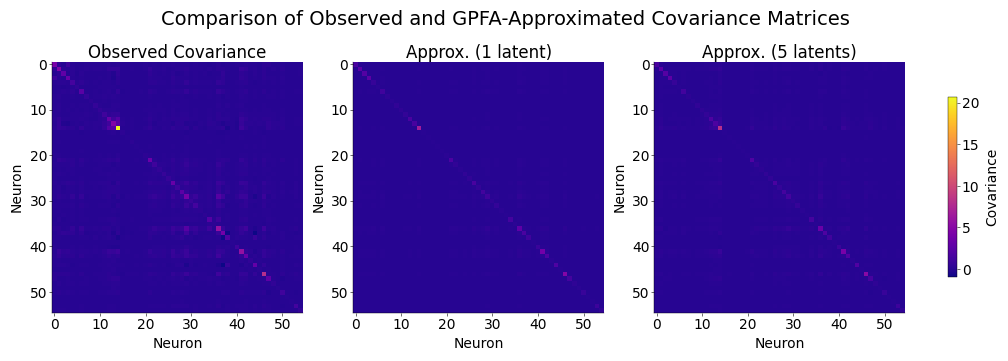

In [207]:
# --------------------------------------------------------------
# Complete the analytical solution for the covariance matrix of
# the approximation using the provide equations (2 pts)
# --------------------------------------------------------------


def cov(fit: engine.PPGPFAfit) -> np.ndarray:
    """
    Compute the analytical approximation of the spike count covariance matrix
    using the log-normal distribution approximation.

    Returns:
        cov_matrix: Covariance approximation (ydim × ydim)
        mu: Mean firing rates (ydim,)
    """

    C = fit.optimParams["C"]  # shape: (ydim, xdim)
    d = fit.optimParams["d"]  # shape: (ydim,)

    CCt = C @ C.T  # shape: (ydim, ydim)
    diag_CCt = np.diag(CCt)

    mu = np.exp(0.5 * diag_CCt + d)  # shape: (ydim,)

    # Outer product of mu vectors
    mu_T = np.outer(mu, mu)  # shape: (ydim, ydim)

    # Covariance matrix
    c = mu_T * np.exp(CCt) + np.diag(mu) - mu_T

    return c, mu


# --------------------------------------------------------------
# Plot the covariance matrix of
# (1) the observed data
# (2) its approximation using 1 latent variable
# (3) its approximation using 5 latent variable
# and explain how they compare (1+1 pts).
# --------------------------------------------------------------

obs_corr = np.cov(data.all_raster)
opt_r1, mu1 = cov(xval.fits[0])
opt_r5, mu5 = cov(xval.fits[4])

# HINT: Think about which type of colormap and ranges are appropriate here.

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5), constrained_layout=True)
# add plot to visualize the differences in the covariance matrices

vmin = np.min([obs_corr, opt_r1, opt_r5])
vmax = np.max([obs_corr, opt_r1, opt_r5])

titles = ["Observed Covariance", "Approx. (1 latent)", "Approx. (5 latents)"]
matrices = [obs_corr, opt_r1, opt_r5]

for ax, mat, title in zip(axs, matrices, titles):
    im = ax.imshow(mat, cmap="plasma", vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("Neuron")
    ax.set_ylabel("Neuron")

fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6, label="Covariance")
plt.suptitle(
    "Comparison of Observed and GPFA-Approximated Covariance Matrices", fontsize=14
)
plt.show()

### Questions

What do you see / expect to see?

_YOUR ANSWER GOES HERE_

- The observed covariance reflects the empirical full pairwise neuron correlations in the spike data. More specifically we see: a bright diagonal — i.e. high variance in individual neurons; off-diagonal structure — some neurons are correlated (e.g. by shared stimulus tuning or population activity patterns); one very bright spot — a neuron with unusually high variance (due to...?)
- The 1-latent model captures mostly the diagonal (variance) structure of the spiking population, but doesn´t capture the off-diagonal (correlation) interactions between neurons. This shows that a single latent state is insufficient to capture more specific neuron-to-neuron interactions
- The 5-latent model closely approximates the observed covariance, capturing both diagonal (variance) and off-diagonal (correlation) structure much better. This reflects what we saw in Task 2 (cross-validation) as model performance improved with increasing latent dimensionality. But still more latent states would surely improve our approximation, exemplary this can be seen in the triagle from neuron 0 to 13/14 and neuron 20 to 47/48. The model with 5 latent state captures the larger correlations in these sections but still fails to replicate smaller correlations.
- The code below implements some metrics to quantitively compare the approximations

In [208]:
from numpy.linalg import eigvalsh, inv, slogdet
import pandas as pd
from IPython.display import display


def frobenius_norm(S1, S2):
    """
    Frobenius norm between two covariance matrices.
    """
    return np.linalg.norm(S1 - S2, ord="fro")


def rv_coefficient(S1, S2):
    """
    RV coefficient between two covariance matrices.
    Measures structural similarity (1 = identical).
    """
    numerator = np.trace(S1 @ S2)
    denominator = np.sqrt(np.trace(S1 @ S1) * np.trace(S2 @ S2))
    return numerator / denominator


def eigenvalue_distance(S1, S2):
    """
    Euclidean distance between the eigenvalue spectra of two matrices.
    """
    e1 = np.sort(eigvalsh(S1))
    e2 = np.sort(eigvalsh(S2))
    return np.linalg.norm(e1 - e2)


def pearson_matrix_corr(S1, S2):
    """
    Pearson correlation between flattened covariance matrices.
    """
    s1 = S1.flatten()
    s2 = S2.flatten()
    return np.corrcoef(s1, s2)[0, 1]


# data
obs_corr = np.cov(data.all_raster)  # observed covariance matrix
opt_r1, mu1 = cov(xval.fits[0])  # 1-latent approximation
opt_r5, mu5 = cov(xval.fits[4])  # 5-latent approximation

metrics = {
    "Frobenius Norm": frobenius_norm,
    "RV Coefficient": rv_coefficient,
    "Eigenvalue Distance": eigenvalue_distance,
    "Pearson Correlation": pearson_matrix_corr,
}

results = {}
for name, func in metrics.items():
    results[name] = {
        "1 latent": func(obs_corr, opt_r1),
        "5 latents": func(obs_corr, opt_r5),
    }

df_metrics = pd.DataFrame(results).T
df_metrics.columns.name = "Model"

# table of metrics
display(df_metrics)

# plot
# plt.figure(figsize=(8, 4))
# sns.heatmap(df_metrics, annot=True, fmt=".3f", cmap="coolwarm")
# plt.title("Quantitative Comparison of Covariance Matrices")
# plt.show()

Model,1 latent,5 latents
Frobenius Norm,19.187566,16.762998
RV Coefficient,0.914652,0.955147
Eigenvalue Distance,18.158621,15.941734
Pearson Correlation,0.914269,0.953295
